# **3D elastic VTI wave equation implementation on a staggered grid**

This is a first attempt at implementing the elastic wave equations in 3D vertical transversely isotropic (VTI) media as described in [1].

This notebook will attempt to implement this FD scheme and recreate the results from both Numerical examples [4.1] and [4.2].

<br> Chirayu Khimji 
<br> Independent Research Project 
<br> MSc Applied Computational Science and Engineering - Imperial College London 
<br> IRP Supervisors: Dr. Gerard Gorman, Dr. Rhodri Nelson and the Devito Project Research Group


## Introduction

To be added in proper academic syntax


## Outline
this cell needs to be completed in more detail when tasks below are completed

1. Scalar PDE Implementation for 3D elastic VTI wave propagation using temporal high-accuracy staggered-grid finite-difference scheme

2. Vectorial PDE Implementation for 3D elastic VTI wave propagation (Vectorized Approach) using temporal high-accuracy staggered-grid finite-difference scheme

3. Implement 3D elastic VTI wave propagation using an optimal k-space operator-based temporal high-accuracy staggered-grid finite-difference scheme i.e. like the paper [1].

4. Testing: Compare the resultants of these two implemenations to make sure everything works

# Scalar PDE Implementation: 3D Elastic VTI wave-equations
The paper expresses the elastic wave equations as a set of scalar PDEs in conventional velocity-stress format: 

$$
\begin{aligned}
\frac{\partial v_x}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xx}}{\partial x} + \frac{\partial \tau_{xy}}{\partial y} + \frac{\partial \tau_{xz}}{\partial z} \right) \\
\frac{\partial v_y}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xy}}{\partial x} + \frac{\partial \tau_{yy}}{\partial y} + \frac{\partial \tau_{yz}}{\partial z} \right) \\
\frac{\partial v_z}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xz}}{\partial x} + \frac{\partial \tau_{yz}}{\partial y} + \frac{\partial \tau_{zz}}{\partial z} \right) \\
\frac{\partial \tau_{xx}}{\partial t} &= c_{11}\frac{\partial v_{x}}{\partial x} + c_{11}\frac{\partial v_{y}}{\partial y} - 2c_{66}\frac{\partial v_{y}}{\partial y} + c_{13}\frac{\partial v_{z}}{\partial z} \\
\frac{\partial \tau_{yy}}{\partial t} &= c_{11}\frac{\partial v_{x}}{\partial x} - 2c_{66}\frac{\partial v_{x}}{\partial x} + c_{11}\frac{\partial v_{y}}{\partial y} + c_{13}\frac{\partial v_{z}}{\partial z} \\
\frac{\partial \tau_{zz}}{\partial t} &= c_{13}\frac{\partial v_{x}}{\partial x} + c_{13}\frac{\partial v_{y}}{\partial y} + c_{33}\frac{\partial v_{z}}{\partial z} \\
\frac{\partial \tau_{zz}}{\partial t} &= c_{44}\frac{\partial v_{z}}{\partial x} + c_{44}\frac{\partial v_{x}}{\partial z} \\
\frac{\partial \tau_{yz}}{\partial t} &= c_{44}\frac{\partial v_{z}}{\partial y} + c_{44}\frac{\partial v_{y}}{\partial z} \\
\frac{\partial \tau_{xy}}{\partial t} &= c_{66}\frac{\partial v_{y}}{\partial x} + c_{66}\frac{\partial v_{x}}{\partial y} \\
\end{aligned}
$$

Stiffness coefficients in elastic VTI media can be given by (Thomsen 1986):

$
\begin{aligned}
c_{11} &= \rho \left(1 + 2\epsilon\right)v_{p0}^{2} \\
c_{33} &= \rho v_{p0}^{2} \\
c_{44} &= \rho v_{s0}^{2} \\
c_{66} &= \rho \left(1 + 2\gamma\right)v_{s0}^{2} \\
c_{13} &= \rho v_{p0}^{2}\sqrt{f\left(f + 2\delta\right)} - \rho v_{s0}^{2} \\
f &= 1 - v_{s0}^{2}/v_{p0}^{2} \\
\end{aligned}
$




## Imports
all required imports used in this notebook are below for consistency.

In [1]:
# Required imports:
import numpy as np
import sympy as sp

from devito import *
from examples.seismic import RickerSource, TimeAxis, Receiver
from examples.seismic import plot_image, plot_velocity, plot_perturbation
from examples.seismic import ModelElasticVTI

import matplotlib.pyplot as plt

from sympy import init_printing, latex
init_printing(use_latex='mathjax')

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline

plt.rc('font', size=14)

# define 32 bit floating point as the precision type 
dtype = np.float32

# Set the default language to openmp
#configuration['language'] = 'openmp'

# Set logging to debug, captures statistics on the performance of operators
configuration['log-level'] = 'DEBUG'


## Instantiate the Devito grid for a three dimensional problem
define the grid the same as the 3D homogenous model described in 4.1. This still needs to be fixed below is a sample structure

In [2]:
# Define dimensions for the interior of the model - Setup equivalent to elastic notebook
nx, ny, nz = 201, 201, 201
dx, dy, dz = 7.5, 7.5, 7.5          # Grid spacing in m
shape = (nx, ny, nz)                 # Number of grid points
spacing = (dx, dy, dz)               # Domain size is now 5 km by 5 km
origin = (0., 0., 0.)                # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

#Thomsen's anisotropy parameters
epsilon = 0.25
delta = 0.10
gamma = 0.05

#initial conditions
npad = 0
vp = 2.0 #km/s
vs = 1.0 #km/s
rho= 1.8 #kg/m**3

so = 2 #spatial order
to = 1 #temporal order

model = ModelElasticVTI(origin=origin, spacing = spacing, shape=shape, space_order=so, 
vp=vp, vs=vs, rho=rho, epsilon=epsilon, delta=delta, gamma=gamma, nbl=npad)

print("")
print("grid.shape:       ", model.grid.shape)
print("grid.origin:      ", origin)
print("grid.spacing_map: ", model.grid.spacing_map)
print("grid.extent:      ", model.grid.extent)



grid.shape:        (201, 201, 201)
grid.origin:       (0.0, 0.0, 0.0)
grid.spacing_map:  {h_x: 7.5, h_y: 7.5, h_z: 7.5}
grid.extent:       (1500.0, 1500.0, 1500.0)


In [3]:
# Now we create the velocity and pressure fields
# PDE fn's:
x, y, z = model.grid.dimensions
damp = model.damp

#Velocity
v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=to)

#Stress
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=to)

# Symbolic representation of the model grid spacing
s = model.grid.stepping_dim.spacing 


## Define the simulation time range


In [4]:
t0 = 0.     # Simulation time start
tn = 300.  # Simulation time end (1 second = 1000 msec)

#dt = 1.178511301977579 # time step in elastic notebook
dt = model.critical_dt #CFL condition

time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time range: ", time_range)

Time range:  TimeAxis: start=0, stop=301.76, step=1.84, num=165


## Define the acquisition geometry: locations of explosive source and recievers

For Numercial Example [4.1] in [1]:
A 10 Hz center frequency Ricker wavelet source, located at (x, y, z) = (750m, 750m, 750m) and is added into $v_x$ component to generate vibration.

For Ricker wavelet, the source signature $g(t)$ is the derivative of a Gaussian pulse:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

Allocating memory for src(165, 1)
Allocating memory for src_coords(1, 3)
Allocating memory for rec_coords(201, 3)
src_coords [x,y,z]: [[750. 750. 750.]]


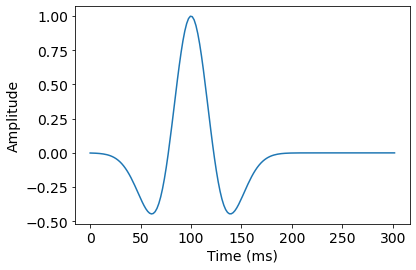

In [5]:
# Centered Source with 10 Hz center frequency
fpeak = 0.010
src = RickerSource(name='src', grid=model.grid, f0=fpeak, time_range=time_range)

#src.coordinates.data[:] = np.array([1800., 1800., 1800.])
src.coordinates.data[:] = np.array([750., 750., 750.])

# line of receivers along right edge of model
## this needs to be fixed later on to be in line with the paper
rec = Receiver(name='rec', grid=model.grid, npoint=nz, time_range=time_range)
rec.coordinates.data[:] = np.array([3600., 3600., 1800.])

print("src_coords [x,y,z]:", src.coordinates.data)
#print("rec_coords [x,y,z]:", rec.coordinates.data)

#plot time signature to view wavelet
src.show()

In [6]:
# Create interpolation expression for receivers
rec_term_no = rec.interpolate(expr=tau.forward)

irho = model.irho
ro = model.rho

# Thomsen's stiffness coefficients in elastic VTI media from The stiffness matrix, otherwise known as the elastic modulus matrix
# these coefficients are computed by ModelElasticVTI
#c11 = ro*(1+2*eps)*vp**2
#c33 = ro*vp**2
#c44 = ro*vs**2
#c66 = ro*(1+2*gamma)*vs**2
#f = 1 - vs**2/vp**2
#c13 = ro*vp**2*sp.sqrt(f*(f+2*delta))-ro*vs**2

c11 = model.c11
c33 = model.c33
c44 = model.c44
c66 = model.c66
c13 = model.c13


## Assemble scalar PDEs individually


In [7]:
#source injection term
src_xx = src.inject(field=tau[0, 0].forward, expr=src*s)
src_yy = src.inject(field=tau[1, 1].forward, expr=src*s)
src_zz = src.inject(field=tau[2, 2].forward, expr=src*s)
src_term = src_xx + src_yy + src_zz

In [8]:
# Particle Velocity for each direction
u_vx = Eq(v[0].forward, v[0] + s*irho*(tau[0,0].dx + tau[1,0].dy + tau[2,0].dz) )
u_vy = Eq(v[1].forward, v[1] + s*irho*(tau[0,1].dx + tau[1,1].dy + tau[1,2].dz) )
u_vz = Eq(v[2].forward, v[2] + s*irho*(tau[0,2].dx + tau[2,1].dy + tau[2,2].dz) )

# Stress for each direction in VTI Media:
u_txx = Eq(tau[0,0].forward, tau[0,0] + s*(c11*v[0].forward.dx + c11*v[1].forward.dy - 2*c66*v[1].forward.dy + c13*v[2].forward.dz) )
u_tyy = Eq(tau[1,1].forward, tau[1,1] + s*(c11*v[0].forward.dx - 2*c66*v[0].forward.dx + c11*v[1].forward.dy + c13*v[2].forward.dz) )
u_tzz = Eq(tau[2,2].forward, tau[2,2] + s*(c13*v[0].forward.dx + c13*v[1].forward.dy + c33*v[2].forward.dz) )

u_txz = Eq(tau[0,2].forward, tau[0,2] + s*(c44*v[2].forward.dx + c44*v[0].forward.dz) )
u_tyz = Eq(tau[1,2].forward, tau[1,2] + s*(c44*v[2].forward.dy + c44*v[1].forward.dz) )
u_txy = Eq(tau[0,1].forward, tau[0,1] + s*(c66*v[1].forward.dx + c66*v[0].forward.dy) )

stencil = [u_vx, u_vy, u_vz, u_txx, u_tyy, u_tzz, u_txz, u_tyz, u_txy]


In [9]:
#Assemble the operator 
op1 = Operator(stencil + src_term, subs=model.spacing_map)

Operator `Kernel` generated in 1.46 s
  * lowering.Expressions: 0.54 s (37.2 %)
  * lowering.Clusters: 0.50 s (34.4 %)
  * lowering.IET: 0.34 s (23.4 %)
Flops reduction after symbolic optimization: [133 --> 78]


In [10]:
#Uncomment to Print generated c++ code
#print(op1)

In [11]:
#NBVAL_IGNORE_OUTPUT

#Forward Simulation
op1(dt=dt) 

Allocating memory for t_xx(2, 205, 205, 205)
Allocating memory for t_xy(2, 205, 205, 205)
Allocating memory for t_xz(2, 205, 205, 205)
Allocating memory for t_yy(2, 205, 205, 205)
Allocating memory for t_yz(2, 205, 205, 205)
Allocating memory for t_zz(2, 205, 205, 205)
Allocating memory for v_x(2, 205, 205, 205)
Allocating memory for v_y(2, 205, 205, 205)
Allocating memory for v_z(2, 205, 205, 205)
Operator `Kernel` fetched `/var/folders/kb/bc2lwpvd4kj2k3qjll_cmwp80000gn/T/devito-jitcache-uid501/8bc36655706f77bcb9cf8acc0a0ff6c2811e9d92.c` in 0.22 s from jit-cache
Operator `Kernel` run in 22.10 s
Global performance indicators
  * Achieved 0.06 FD-GPts/s
Local performance indicators
  * section0<<164,25,201,8,201>,<164,25,201,8,201>,<164,25,201,8,201>,<164,25,25,8,8,201>> with OI=0.65 computed in 22.10 s [4.71 GFlops/s, 0.55 GPts/s]
  * section1<<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,

PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=22.096097000000004, gflopss=4.701225197916174, gpointss=0.5424490612980201, oi=0.6457053818108919, ops=78, itershapes=((164, 25, 201, 8, 201), (164, 25, 201, 8, 201), (164, 25, 201, 8, 201), (164, 25, 25, 8, 8, 201)))),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.00020099999999999957, gflopss=0.35492537313432915, gpointss=0.01958208955223885, oi=21.75, ops=435, itershapes=((164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1))))])

Inspect the shape of the data stored in one of our time functions:

In [12]:
#Inspect the Data
#v[0].data

In [13]:
print(" ")
print("Shape:", v[0].data.shape)
print("Total number of instances in time range:", time_range.num)


Shape: (2, 201, 201, 201)
Total number of instances in time range: 165


In [14]:
print("final time step stored index given by:", np.mod(time_range.num,2))

final time step stored index given by: 1


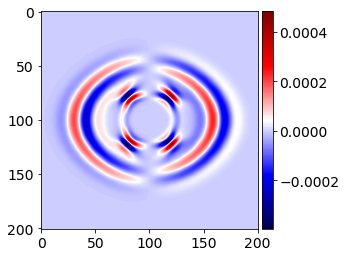

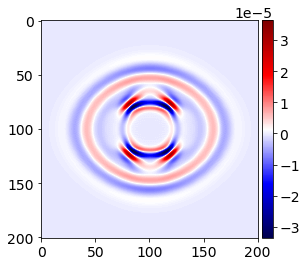

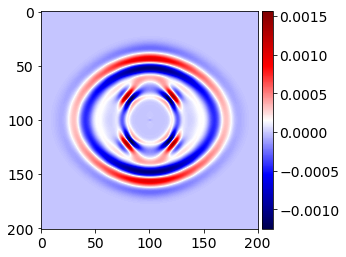

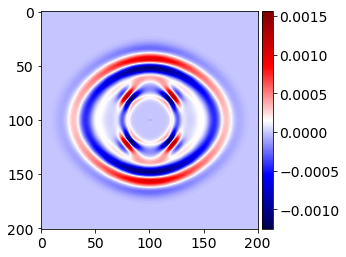

In [15]:
#NBVAL_SKIP

# Mid-points:
mid_x = int(0.5*(v[0].data.shape[1]-1))+1
mid_y = int(0.5*(v[0].data.shape[2]-1))+1

# Plot some selected results:

plot_image(v[0].data[1, :, mid_y, :], cmap="seismic")
plot_image(v[0].data[1, mid_x, :, :], cmap="seismic")

plot_image(tau[2, 2].data[1, :, mid_y, :], cmap="seismic")
plot_image(tau[2, 2].data[1, mid_x, :, :], cmap="seismic")

In [16]:
assert np.isclose(norm(v[0]), 0.14121853, atol=1e-4, rtol=0)

## Testing Scalar Implementation: Reduce $C_{VTI}$ to $C_{ISO}$ 

In order to test that the Scale PDE Implementation is correct, the stress tensor for VTI media can be made isotropic and should retrieve Elastic wave equations for Isotropic media. The results generated from the converted VTI stress tensor should reproduce equivalent results as a purely Isotropic elastic problem. The elastic test case should have an identical problem setup as the elastic VTI case i.e. equivalent grid setup, model, sources etc. This test will be used to verify that the Scalar PDE Implementation of 3D Elastic VTI wave-equations is correct.


Elastic Coefficient Matrix for VTI Media [2]:

$C_{VTI} = \begin{bmatrix}c_{11} & c_{11} - 2c_{66} & c_{13} & 0 & 0 & 0 \\ c_{11} - 2c_{66} & c_{11} & c_{13} & 0 & 0 & 0 \\ c_{13} & c_{13} & c_{33} & 0 & 0 & 0 \\ 0 & 0 & 0 & c_{44} & 0 & 0 \\ 0 & 0 & 0 & 0 & c_{44} & 0 \\ 0 & 0 & 0 & 0 & 0 & c_{66} \end{bmatrix} \\ $
Where the compenents are stiffness coefficients as explained previously. 

For Isotropic media, Elastic Coefficient Matrix reduces to [3]:

$ C_{ISO} = \begin{bmatrix} \lambda + 2\mu & \lambda & \lambda & 0 & 0 & 0 \\ \lambda & \lambda + 2\mu & \lambda & 0 & 0 & 0 \\ \lambda & \lambda & \lambda + 2\mu & 0 & 0 & 0 \\ 0 & 0 & 0 & \mu & 0 & 0 \\ 0 & 0 & 0 & 0 & \mu & 0 \\ 0 & 0 & 0 & 0 & 0 & \mu \end{bmatrix} \\ $

where $\lambda$ and $\mu$ are Lamé parameters.


### Make the stress tensor for VTI media isotropic:

By comparing both the matrices above, it is convenient to express the stiffness coefficients for VTI media in terms of generalized Lamé parameters:

$
\begin{aligned}
c_{11} &= \lambda + 2\mu \\
c_{33} &= \lambda + 2\mu \\
c_{44} &= \mu \\
c_{66} &= \mu \\
c_{13} &= \lambda \\
c_{11} - 2c_{66} &= \lambda \\ 
\end{aligned}
$


Hence:

$
\begin{aligned}
c_{11} &= c_{33} \\
c_{44} &= c_{66} \\
c_{13} &= c_{11} - 2c_{66} \\
\end{aligned}
$




In [10]:
# Setup VTI Stress tensor for Isotropic media
c11 = c33
c44 = c66
c13 = c11 - 2*c66

In [11]:
# Particle Velocity for each direction
u_vx = Eq(v[0].forward, v[0] + s*irho*(tau[0,0].dx + tau[1,0].dy + tau[2,0].dz) )
u_vy = Eq(v[1].forward, v[1] + s*irho*(tau[0,1].dx + tau[1,1].dy + tau[1,2].dz) )
u_vz = Eq(v[2].forward, v[2] + s*irho*(tau[0,2].dx + tau[2,1].dy + tau[2,2].dz) )

# Stress for each direction in VTI Media:
u_txx = Eq(tau[0,0].forward, tau[0,0] + s*(c11*v[0].forward.dx + c11*v[1].forward.dy - 2*c66*v[1].forward.dy + c13*v[2].forward.dz) )
u_tyy = Eq(tau[1,1].forward, tau[1,1] + s*(c11*v[0].forward.dx - 2*c66*v[0].forward.dx + c11*v[1].forward.dy + c13*v[2].forward.dz) )
u_tzz = Eq(tau[2,2].forward, tau[2,2] + s*(c13*v[0].forward.dx + c13*v[1].forward.dy + c33*v[2].forward.dz) )

u_txz = Eq(tau[0,2].forward, tau[0,2] + s*(c44*v[2].forward.dx + c44*v[0].forward.dz) )
u_tyz = Eq(tau[1,2].forward, tau[1,2] + s*(c44*v[2].forward.dy + c44*v[1].forward.dz) )
u_txy = Eq(tau[0,1].forward, tau[0,1] + s*(c66*v[1].forward.dx + c66*v[0].forward.dy) )

stencil = [u_vx, u_vy, u_vz, u_txx, u_tyy, u_tzz, u_txz, u_tyz, u_txy]

#Assemble the operator 
op2 = Operator(stencil + src_term, subs=model.spacing_map)

Operator `Kernel` generated in 1.26 s
  * lowering.Clusters: 0.51 s (40.8 %)
  * lowering.Expressions: 0.37 s (29.6 %)
  * lowering.IET: 0.29 s (23.2 %)
Flops reduction after symbolic optimization: [137 --> 79]


In [12]:
#NBVAL_IGNORE_OUTPUT

#Forward Simulation
op2 (dt=dt)

Allocating memory for t_xx(2, 205, 205, 205)
Allocating memory for t_xy(2, 205, 205, 205)
Allocating memory for t_xz(2, 205, 205, 205)
Allocating memory for t_yy(2, 205, 205, 205)
Allocating memory for t_yz(2, 205, 205, 205)
Allocating memory for t_zz(2, 205, 205, 205)
Allocating memory for v_x(2, 205, 205, 205)
Allocating memory for v_y(2, 205, 205, 205)
Allocating memory for v_z(2, 205, 205, 205)
Operator `Kernel` fetched `/var/folders/kb/bc2lwpvd4kj2k3qjll_cmwp80000gn/T/devito-jitcache-uid501/62c3f4ac37b68720373ecd8bcef9bc8bae089a6c.c` in 0.22 s from jit-cache
Operator `Kernel` run in 22.32 s
Global performance indicators
  * Achieved 0.06 FD-GPts/s
Local performance indicators
  * section0<<164,25,201,8,201>,<164,25,201,8,201>,<164,25,201,8,201>,<164,25,25,8,8,201>> with OI=0.66 computed in 22.32 s [4.72 GFlops/s, 0.54 GPts/s]
  * section1<<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,

PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=22.31334100000001, gflopss=4.715139097995229, gpointss=0.5371677453412286, oi=0.6539836559366725, ops=79, itershapes=((164, 25, 201, 8, 201), (164, 25, 201, 8, 201), (164, 25, 201, 8, 201), (164, 25, 25, 8, 8, 201)))),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.0002139999999999996, gflopss=0.3333644859813091, gpointss=0.018392523364486015, oi=21.75, ops=435, itershapes=((164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1))))])

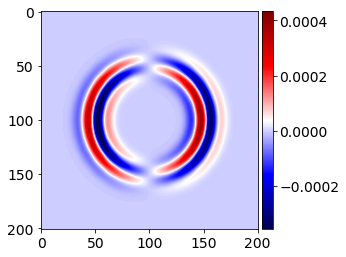

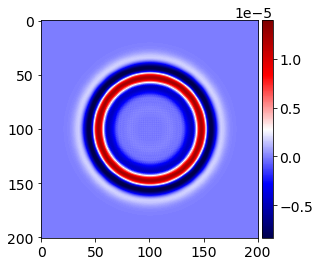

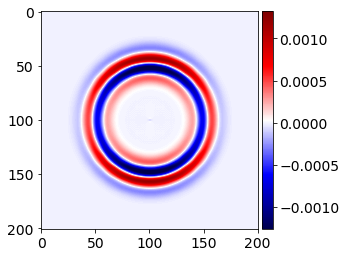

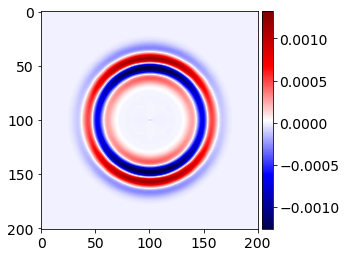

In [13]:
#NBVAL_SKIP

# Mid-points:
mid_x = int(0.5*(v[0].data.shape[1]-1))+1
mid_y = int(0.5*(v[0].data.shape[2]-1))+1

# Plot some selected results:

plot_image(v[0].data[1, :, mid_y, :], cmap="seismic")
plot_image(v[0].data[1, mid_x, :, :], cmap="seismic")

plot_image(tau[2, 2].data[1, :, mid_y, :], cmap="seismic")
plot_image(tau[2, 2].data[1, mid_x, :, :], cmap="seismic")

In [15]:
assert np.isclose(norm(v[0]), 0.17922576, atol=1e-4, rtol=0)

### Compare against Elastic Wave Equation in Vectorial form for Isotropic Media from the elastic notebook:

In [8]:
# Thorbecke's parameter notation
cp2 = vp*vp
cs2 = vs*vs

mu = cs2*ro
l = (cp2*ro - 2*mu)

In [9]:
# fdelmodc reference implementation
u_v = Eq(v.forward, v + s*irho*div(tau))
u_t = Eq(tau.forward, tau + s * l * diag(div(v.forward)) + s * mu * (grad(v.forward) + grad(v.forward).T))
stencil = [u_v, u_t]

op3 = Operator(stencil + src_term,  subs=model.spacing_map)

Operator `Kernel` generated in 1.42 s
  * lowering.Expressions: 0.52 s (36.8 %)
  * lowering.Clusters: 0.49 s (34.7 %)
  * lowering.IET: 0.34 s (24.1 %)
Flops reduction after symbolic optimization: [141 --> 73]


In [10]:
#NBVAL_IGNORE_OUTPUT

#Forward Simulation
op3(dt = dt)

Allocating memory for t_xx(2, 205, 205, 205)
Allocating memory for t_xy(2, 205, 205, 205)
Allocating memory for t_xz(2, 205, 205, 205)
Allocating memory for t_yy(2, 205, 205, 205)
Allocating memory for t_yz(2, 205, 205, 205)
Allocating memory for t_zz(2, 205, 205, 205)
Allocating memory for v_x(2, 205, 205, 205)
Allocating memory for v_y(2, 205, 205, 205)
Allocating memory for v_z(2, 205, 205, 205)
Operator `Kernel` fetched `/var/folders/kb/bc2lwpvd4kj2k3qjll_cmwp80000gn/T/devito-jitcache-uid501/19acfe76718577e9874b1006933573b477c0c80d.c` in 0.22 s from jit-cache
Operator `Kernel` run in 22.19 s
Global performance indicators
  * Achieved 0.06 FD-GPts/s
Local performance indicators
  * section0<<164,25,201,8,201>,<164,25,201,8,201>,<164,25,201,8,201>,<164,25,25,8,8,201>> with OI=0.61 computed in 22.18 s [4.39 GFlops/s, 0.55 GPts/s]
  * section1<<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,<164,1>,

PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=22.179719000000013, gflopss=4.383276234112793, gpointss=0.5404039192741799, oi=0.6043140111819886, ops=73, itershapes=((164, 25, 201, 8, 201), (164, 25, 201, 8, 201), (164, 25, 201, 8, 201), (164, 25, 25, 8, 8, 201)))),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.00021599999999999956, gflopss=0.3302777777777785, gpointss=0.01822222222222226, oi=21.75, ops=435, itershapes=((164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1), (164, 1))))])

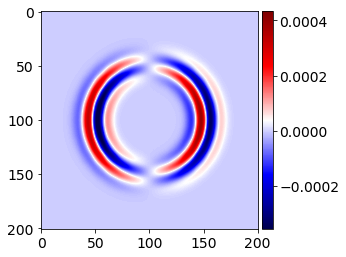

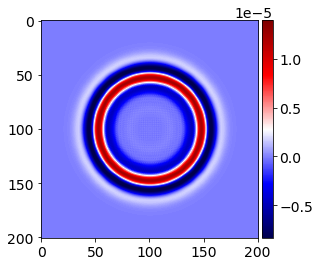

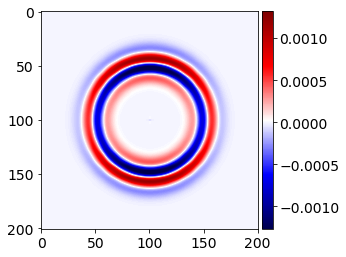

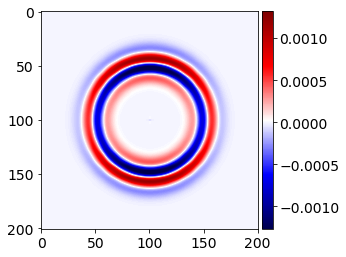

In [11]:
#NBVAL_SKIP
##Plots seem inaccurate, code currently being debugged
# Mid-points:
mid_x = int(0.5*(v[0].data.shape[1]-1))+1
mid_y = int(0.5*(v[0].data.shape[2]-1))+1

# Plot some selected results:

plot_image(v[0].data[1, :, mid_y, :], cmap="seismic")
plot_image(v[0].data[1, mid_x, :, :], cmap="seismic")

plot_image(tau[2, 2].data[1, :, mid_y, :], cmap="seismic")
plot_image(tau[2, 2].data[1, mid_x, :, :], cmap="seismic")

In [13]:
assert np.isclose(norm(v[0]), 0.17922495, atol=1e-4, rtol=0)

Tests seem successful - conclusion of testing to be added here (convergence tests, norm of the difference, make sure norm of difference is roughly same over many time steps, check results are same in terms of tolerance)

# Vectorial PDE Implementation: assemble PDE in Vectorial form - Still in progress

## Scalar PDEs converted into Vectorial form

Elastic Coefficient Matrix for VTI Media [2]:

$C_{VTI} = \begin{bmatrix}c_{11} & c_{11} - 2c_{66} & c_{13} & 0 & 0 & 0 \\ c_{11} - 2c_{66} & c_{11} & c_{13} & 0 & 0 & 0 \\ c_{13} & c_{13} & c_{33} & 0 & 0 & 0 \\ 0 & 0 & 0 & c_{44} & 0 & 0 \\ 0 & 0 & 0 & 0 & c_{44} & 0 \\ 0 & 0 & 0 & 0 & 0 & c_{66} \end{bmatrix} \\ $

The elastic coefficient matrix for VTI media is taken into the vectorial form of the elastic wave equation in order to derive the Scalar PDEs given by the paper [1]. In order to easily implement $C_{VTI}$ into the Elastic Wave equations' vectorial form, we can disregard its zero elements and spilt $C_{VTI}$ into two distinct $(3$x$3)$ matrices $C_1$ and $C_2$:

$
\begin{aligned}
C_{1} &= \begin{bmatrix}c_{11} & c_{11} - 2c_{66} & c_{13} \\ c_{11} - 2c_{66} & c_{11} & c_{13} \\ c_{13} & c_{13} & c_{33} \end{bmatrix} \\ 
\\
C_{2} &= \begin{bmatrix}c_{44} & 0 & 0 \\ 0 & c_{44} & 0 \\ 0 & 0 & c_{66} \end{bmatrix}  \\
\\
\end{aligned}
$

Using $C_1$ and $C_2$, a higher-level representation of the scalar PDEs above can be derived from Hooke's law and the equation of motion:

\begin{cases}
&\frac{dv}{dt} = \nabla . \tau \\
&\frac{d \tau}{dt} = C_1 tr(\nabla v) \mathbf{I}  + C_2(\nabla v + (\nabla v)^T)
\end{cases}

since $tr(\nabla v)$ is the divergence of $v$ we can rewrite it as:

\begin{cases}
&\frac{dv}{dt} = \nabla . \tau \\
&\frac{d\tau}{dt} = C_1 \text{diag}(\nabla . v) + C_2 (\nabla v + (\nabla v)^T)
\end{cases}

where $v$ is a vector valued function:

$v(t, x, y, z) = \left( v_x(t, x, y, z), v_y(t, x, y, z), v_z(t, x, y, z) \right)$

and the stress $\tau$ is a symmetric tensor valued function:


$\tau(t, x, y, z) = \begin{bmatrix}\tau_{xx}(t, x, y, z) & \tau_{xy}(t, x, y, z) & \tau_{xz}(t, x, y, z) \\\tau_{xy}(t, x, y, z) & \tau_{yy}(t, x, y, z) & \tau_{xy}(t, x, y, z) \\ \tau_{xz}(t, x, y, z) & \tau_{xy}(t, x, y, z) & \tau_{zz}(t, x, y, z) \end{bmatrix}$


This representation provides a higher-level of abstraction and makes the implementation of this SG-FD scheme relatively simple using Devito's high-level tensorial types.



In [24]:
c11 = model.c11
c33 = model.c33
c44 = model.c44
c66 = model.c66
c13 = model.c13

#Assemble full C matrix for VTI media
C = np.diagflat([c11,c11,c33,c44,c44,c66])
C[0][1] = c11 - 2*c66
C[1][0] = C[0][1]
C[0][2] = c13
C[2][0] = C[0][2]
C[2][1] = C[0][2]
C[1][2] = C[2][1]

##for vectorial PDE
#Split full C matrix for VTI media
C1 = sp.Matrix([[c11, c11 - 2*c66, c13], [c11 - 2*c66, c11, c13], [c13, c13, c33]])
C2 = sp.Matrix([[c44, 0, 0], [0, c44, 0], [0, 0, c66]])
C1 = TensorFunction(name='C1', components=C1, grid=model.grid)
C2 = TensorFunction(name='C2', components=C2, grid=model.grid, diagonal = True)

print('Full Elastic Coefficient Matrix:', C)

Full Elastic Coefficient Matrix: [[c11 c11 - 2*c66 c13 0 0 0]
 [c11 - 2*c66 c11 c13 0 0 0]
 [c13 c13 c33 0 0 0]
 [0 0 0 c44 0 0]
 [0 0 0 0 c44 0]
 [0 0 0 0 0 c66]]


In [25]:
print(type(C1))
C1

<class 'devito.types.tensor.C1'>


SymmetricTensor( c11, c11 - 2*c66, c13, c33,)

In [26]:
print(type(C2))
C2

<class 'devito.types.tensor.C2'>


DiagonalTensor( c44, c44, c66,)

In [27]:
##This needs to be fixed

# Particle Velocity for VTI Media
u_v = Eq(v.forward, v + s*irho*div(tau))

# Stress Equation stencil for the elastic case needs to be fixed for Elastic VTI

#Assembles the PDE symbolically
u_t = Eq(tau.forward, tau + s * C1 * diag(div(v.forward)) + s * C2 * (grad(v.forward) + grad(v.forward).T)) ##need to fix this line 
stencil = [u_v, u_t]

#u_v check
#u_v

In [28]:
#u_t check
#u_t

In [29]:
#Assemble the operator 
op_fwd = Operator(stencil + src_term, subs=model.spacing_map)

Operator `Kernel` generated in 1.37 s
  * lowering.Clusters: 0.56 s (41.1 %)
  * lowering.Expressions: 0.42 s (30.9 %)
  * lowering.IET: 0.30 s (22.1 %)
Flops reduction after symbolic optimization: [175 --> 85]


In [30]:
#NBVAL_IGNORE_OUTPUT

#Forward Simulation
op_fwd(dt=dt)

Operator `Kernel` fetched `/var/folders/kb/bc2lwpvd4kj2k3qjll_cmwp80000gn/T/devito-jitcache-uid501/599d3df71f2a828661ecdaaf3cbc850fa218ba54.c` in 0.21 s from jit-cache
Operator `Kernel` run in 37.65 s
Global performance indicators
  * Achieved 0.06 FD-GPts/s
Local performance indicators
  * section0<<255,25,201,8,201>,<255,25,201,8,201>,<255,25,201,8,201>,<255,25,25,8,8,201>> with OI=0.71 computed in 37.65 s [4.68 GFlops/s, 0.50 GPts/s]
  * section1<<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>,<255,1>> with OI=21.75 computed in 0.01 s [0.36 GFlops/s, 0.02 GPts/s]
Performance[mode=advanced] arguments: {'x0_blk0_size': 8, 'x1_blk0_size': 8, 'y0_blk0_size': 8}


PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=37.648968000000046, gflopss=4.675135495745853, gpointss=0.4950143466083845, oi=0.7045671025248229, ops=85, itershapes=((255, 25, 201, 8, 201), (255, 25, 201, 8, 201), (255, 25, 201, 8, 201), (255, 25, 25, 8, 8, 201)))),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.0003130000000000009, gflopss=0.3543929712460054, gpointss=0.01955271565495202, oi=21.75, ops=435, itershapes=((255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1), (255, 1))))])

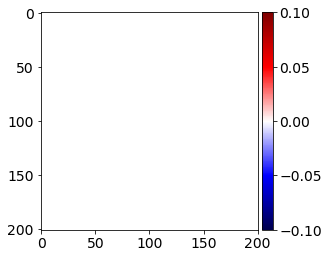

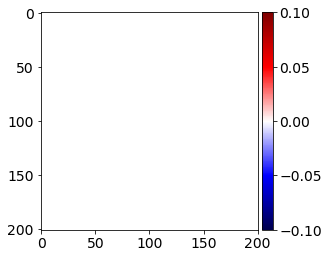

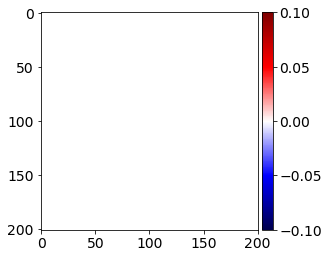

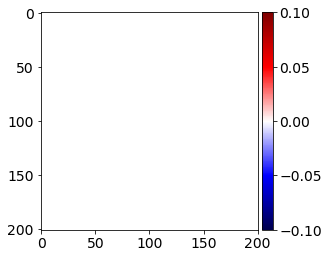

In [31]:
#NBVAL_SKIP

# Mid-points:
mid_x = int(0.5*(v[0].data.shape[1]-1))+1
mid_y = int(0.5*(v[0].data.shape[2]-1))+1

# Plot some selected results:

plot_image(v[0].data[1, :, mid_y, :], cmap="seismic")
plot_image(v[0].data[1, mid_x, :, :], cmap="seismic")

plot_image(tau[2, 2].data[1, :, mid_y, :], cmap="seismic")
plot_image(tau[2, 2].data[1, mid_x, :, :], cmap="seismic")

# References

[1] Xu, S. and Liu, Y., 2019. Modeling 3D elastic VTI wave propagation using an optimal k-space operator-based temporal high-accuracy staggered-grid finite-difference scheme. Journal of Applied Geophysics, 170, p.103847.

[2] Wang, Y., Mu, P., Duan, Y. and Wang, T., 2018. Numerical Simulation of Elastic Wave Equation and Analysis of Wave Field Characteristics in 2-D VTI Medium. Open Journal of Yangtze Oil and Gas, 3(03), p.153.

[3] Bloot, R., Schleicher, J. and Santos, L.T., 2013. On the elastic wave equation in weakly anisotropic VTI media. Geophysical Journal International, 192(3), pp.1144-1155.
